# 1. Daily closing prices for Facebook

## Obtain and plot price data

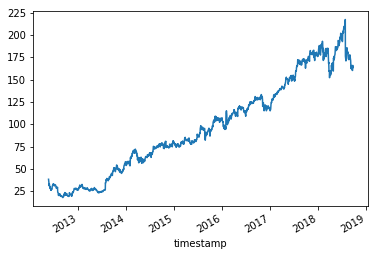

In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, solve, det
from scipy.optimize import leastsq

r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=83SCGSM1BQW0WE86&datatype=csv')
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=FB&outputsize=full&apikey=83SCGSM1BQW0WE86&datatype=csv'
source = requests.get(url).content.decode().split("\n")

data = pd.read_csv(url, index_col=0, parse_dates=True)
data.head()
data['close'].plot()
plt.show()

In [7]:
# Further data work and saving to .csv

data.head()
data.to_csv('FBprices.csv')

**Notes and current to-dos:**

* (DONE) Store dataset
* More companies (note can only request from Alpha Vantage five times every min)
* Update and store data in a structured, separate panel dataset created by the queries that is regularly updated - initial work will happen on this
* Basic summary stats for prices - this will later become an indicator table
* Non-price indicators, e.g. other financial data (may have to pull this from another source)

## Estimation

## LPPL math - working

In [163]:
## Variables

# Intercept (column vector of ones)

data['const'] = 1

# Time counter

data['t'] = range(len(data['const']))

# Initial values

data['tc'] = len(data['const'])+1 # currently tomorrow
data['m'] = np.random.uniform(0, 1) # recommended filter bound
data['ω'] = np.random.randint(4, 26) # recommended filter bound; integers for simplicity

# Defining function to minimize

const = np.array(data['const'])
x0 = np.array([data['tc'],data['m'],data['ω']])
t = np.array(data['t'])
p = np.array(data['close']).T
y = np.log(p)
                 
def f(x0, t):
    return x0[0] - t**x0[1]

def g(x0, t):
    return ((x0[0]-t)**x0[1])*np.cos(x0[2]*np.log(x0[0]-t))
               
def h(x0,t):
    return ((x0[0]-t)**x0[1])*np.sin(x0[2]*np.log(x0[0]-t))

def X(const, x0, t):
    return np.array([const, f(x0,t), g(x0,t), h(x0,t)]).T

def β_hat(const, x0, t):
    return inv(X(const, x0, t).T @ X(const, x0, t)) @ X(const, x0, t).T @ y

def residual(const, x0, t):
    
    A_hat = const*β_hat(const,x0,t)[0]
    B_hat = β_hat(const,x0,t)[1]
    C_1_hat = β_hat(const,x0,t)[2]
    C_2_hat = β_hat(const,x0,t)[3]

    return y - A_hat - B_hat*f(x0,t) - C_1_hat*g(x0,t) - C_2_hat*h(x0,t)

#nlparams = leastsq(residual, x0, args=(const, t))

print(residual(const,x0,t))

[-0.99017597 -0.89978865 -0.88738378 ... -0.07780217  0.02331315
  0.13563122]


Want to implement the following:
    
$ln(p_{t}) = LPPL(\phi,t) = A + B(f) + C_{1}(g) + C_{2}(h)$

Where $\phi = $

(Up to here)

In [107]:
## 1. Variable creation

# Column vector of ones (intercept)

data['const'] = 1

# Time counter

data['t'] = range(len(data['const']))

# Containers for the non-linear parameters w initial values

data['tc'] = len(data['const'])+1 # currently tomorrow
data['m'] = np.random.uniform(0, 1) # recommended filter bound
data['ω'] = np.random.randint(4, 26) # recommended filter bound; integers for simplicity

# Dependent variables (f, g, and h)

data['f'] = (data['tc']-data['t'])**data['m']
data['g'] = ((data['tc']-data['t'])**data['m'])*np.cos(data['ω']*np.log(data['tc']-data['t']))
data['h'] = ((data['tc']-data['t'])**data['m'])*np.sin(data['ω']*np.log(data['tc']-data['t']))

## 2. Slaving the linear parameters (OLS estimates)

X = np.array([data['const'], data['f'], data['g'], data['h']]).T
p = np.array([data['close']]).T
y = np.log(p)

β_hat = inv(X.T @ X) @ X.T @ y

# Extracting slaved linear parameter estimates

A_hat = β_hat[0]
B_hat = β_hat[1]
C_1_hat = β_hat[2]
C_2_hat = β_hat[3]

## 3. Estimating the non-linear parameters

# Squared residuals

data['A_hat'] = data['const']*A_hat # Gives it the proper dimensions
data['y'] = y

data['sqresid'] = (data['y'] - data['A_hat'] - B_hat*data['f'] - C_1_hat*data['g'] - C_2_hat*data['h'])**2

# Sum of squared residuals

data['ssr'] = data['sqresid'].sum()

data.head()

##SPARE CODE BEGINS HERE

# data.head()

#del df['column_name'] - reminder code for deleting variables

#Optional container code below (simple loop)

#nonlinparams = ['tc', 'm', 'ω']

#for i in nonlinparams:
 #   data[i] = ""
    
#To improve the fit for future, use 'lmfit' from http://cars9.uchicago.edu/software/python/lmfit/lmfit.pdf)

[[ 2.96574797e+00]
 [ 1.15215431e-02]
 [ 2.46769301e-05]
 [-8.40162208e-05]]
